## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [ ]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print('Found object points and image points in: ' + fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        output_fname = './camera_cal/found/' + fname.split('\\')[-1]
        print('Write ChessboardCorners to: ' + output_fname)
        #cv2.imwrite(output_fname, img)
        #plt.imshow(img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

dist_img = cv2.imread('./camera_cal/calibration20.jpg')
img_size = (dist_img.shape[1], dist_img.shape[0])
print(np.array(objpoints).shape)
print(np.array(imgpoints).shape)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print(mtx)
print(dist)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump( dist_pickle, open( "./calibration_pickle.p", "wb" ))

undist_img = cv2.undistort(dist_img, mtx, dist, None, mtx)

#cv2.imshow('undist', undist_img)

## Help Functions

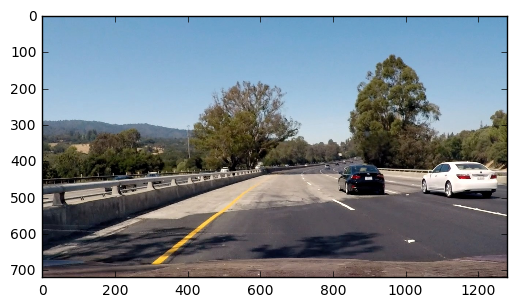

In [15]:
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#fname = "./test_images/straight_lines2.jpg"
fname = "./test_images/test4.jpg"
image = mpimg.imread(fname)
plt.imshow(image)

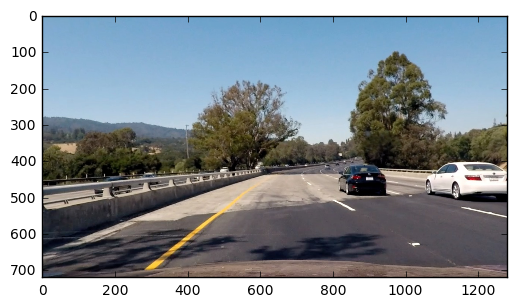

In [16]:
def undistort_image(dist_img):
    dist_pickel = pickle.load(open("./calibration_pickle.p", "rb"))
    mtx = dist_pickel["mtx"]
    dist = dist_pickel["dist"]
        
    undist_img = cv2.undistort(dist_img, mtx, dist, None, mtx)
    
    return undist_img

undist_img = undistort_image(image)

output_fname = "./output_images/" + fname.split('/')[-1]
output_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_fname, output_img)
plt.imshow(undist_img)

In [17]:
import numpy as np

def warp(img, src, dst, inverse=False):
    if inverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return transformed

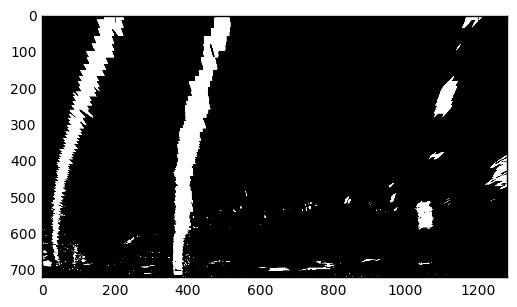

In [19]:
def binary_threshold(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    gray = l_channel#cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    # Sobel x
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

src = np.float32([[195,720], [1120,720], [690, 450], [590,450]])
dst = np.float32([[320,720], [1000,720], [1000,0], [320, 0]])
_,combined_binary = binary_threshold(undist_img)
binary_warped = warp(combined_binary, src, dst)
plt.imshow(binary_warped, cmap='gray')

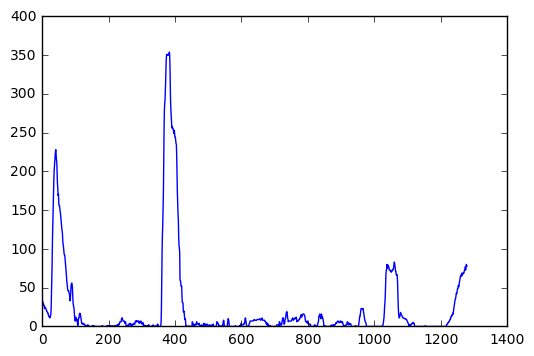

In [20]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

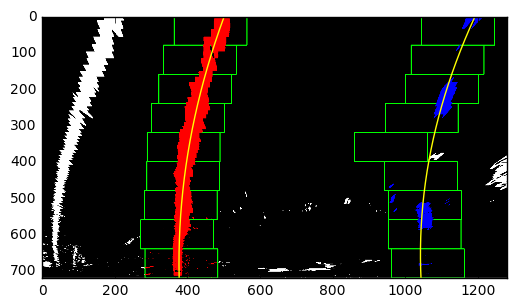

In [21]:
def sliding_window_search(img):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    left_bound = 150
    right_bound = 1150
    leftx_base = np.argmax(histogram[left_bound:midpoint]) + left_bound
    rightx_base = np.argmax(histogram[midpoint:right_bound]) + midpoint
    #print(leftx_base, rightx_base, midpoint)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        #print(win_y_low, win_y_high)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #print(win_xleft_low, win_xleft_high)
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        #print(good_left_inds)
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:
            if len(nonzerox[np.concatenate(left_lane_inds)]):
                leftx_current = np.int(np.mean(nonzerox[np.concatenate(left_lane_inds)]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            if len(nonzerox[np.concatenate(right_lane_inds)]):
                rightx_current = np.int(np.mean(nonzerox[np.concatenate(right_lane_inds)]))
        #print(nonzerox[good_right_inds])
        #print(rightx_current)
    # Concatenate the arrays of indices
    #print(left_lane_inds)
    left_lane_inds = np.concatenate(left_lane_inds)
    #print(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

left_fit, right_fit, out_img = sliding_window_search(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

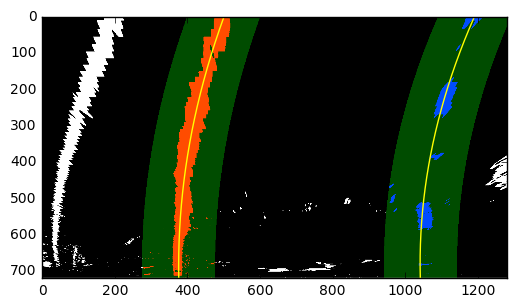

In [22]:
def fit_lane_lines(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

left_fit, right_fit, leftx, lefty, rightx, righty = fit_lane_lines(binary_warped, left_fit, right_fit)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0) 

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
def get_curverad(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

left_curverad, right_curverad = get_curverad(left_fit, right_fit)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

620.785064172 m 506.530106184 m


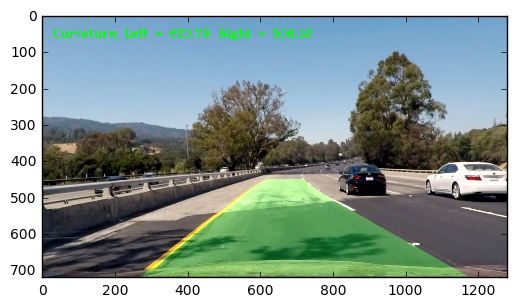

In [24]:
def draw_lines(warped, undist, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = warp(color_warp, src, dst, True)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_curverad, right_curverad = get_curverad(left_fit, right_fit)
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad, 2)) + ", Right = " + str(np.round(right_curverad, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    #deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    #font = cv2.FONT_HERSHEY_COMPLEX    
    #cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
    
    return result
    
result = draw_lines(binary_warped, undist_img, left_fit, right_fit)
plt.imshow(result)

In [28]:
def process_image(image):
    """
    Execute our image processing pipeline on the provided image.
    """
    undistorted = undistort_image(image)
    _, combined_binary = binary_threshold(undistorted)
    
    src = np.float32([[195,720], [1120,720], [690, 450], [590,450]])
    dst = np.float32([[320,720], [1000,720], [1000,0], [320, 0]])
    binary_warped = warp(combined_binary, src, dst, False)
    binary_warped = cv2.GaussianBlur(binary_warped, (5, 5), 0)
    left_fit, right_fit, _ = sliding_window_search(binary_warped)
    result = draw_lines(binary_warped, undistorted, left_fit, right_fit)
    return result

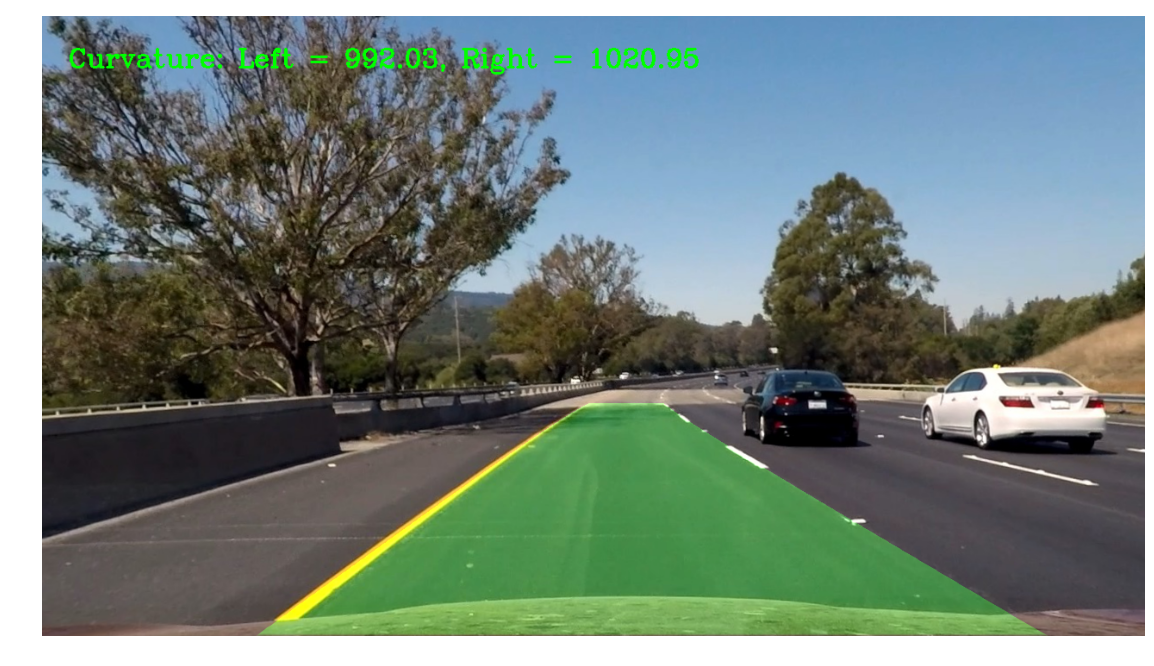

In [29]:
# Run on a test image
img = cv2.imread("test_images/test6.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = "output_images/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4", audio=False)
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:25<00:00,  5.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 3min 27s


In [26]:
video_output = "output_images/challenge_video.mp4"
clip1 = VideoFileClip("challenge_video.mp4", audio=False)
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:13<00:00,  6.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 1min 15s


In [27]:
video_output = "output_images/harder_challenge_video.mp4"
clip1 = VideoFileClip("harder_challenge_video.mp4", audio=False)
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:49<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 3min 51s


In [ ]:
# Buffer for retaining curvature and polygon information between frames
last_rad = None
last_l_poly = None
last_r_poly = None

# Function to apply to frames of video
def pipeline(img):
    global last_rad, last_l_poly, last_r_poly
    
    # Define weights for smoothing
    rad_alpha = 0.05
    poly_alpha = 0.2
    
    # Undistort the image using the camera calibration
    undist_img = undistort_image(img)
    
    # Keep the untransformed image for later
    orig = img.copy()
    
    # Apply perspective transform to the image
    #warp = transform.warp(img)
    
    _,combined_binary = binary_threshold(undist_img)
    binary_warped = warp(combined_binary, src, dst) 
    
    fit_lane_lines(binary_warped)
    
    # Update polynomials using weighted average with last frame
    if last_l_poly is None:
        # If first frame, initialise buffer
        last_l_poly = l_poly
        last_r_poly = r_poly
    else:
        # Otherwise, update buffer
        l_poly = (1 - poly_alpha) * last_l_poly + poly_alpha * l_poly
        r_poly = (1 - poly_alpha) * last_r_poly + poly_alpha * r_poly
        last_l_poly = l_poly
        last_r_poly = r_poly
        
    # Calculate the lane curvature radius
    l_rad = get_curvature(l_poly, mask)
    r_rad = get_curvature(r_poly, mask)
    
    # Get mean of curvatures
    rad = np.mean([l_rad, r_rad])
    
    # Update curvature using weighted average with last frame
    if last_rad is None:
        last_rad = rad
    else:
        last_rad = (1 - rad_alpha) * last_rad + rad_alpha * rad
        
    # Create image
    final = plot_poly_orig(l_poly, r_poly, orig)
        
    # Write radius on image
    cv2.putText(final, 'Lane Radius: {}m'.format(int(last_rad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    # Write lane offset on image
    offset = find_offset(l_poly, r_poly)
    cv2.putText(final, 'Lane Offset: {}m'.format(round(offset, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    return final

In [ ]:
a = 1

b = a 

## Apply a distortion correction to raw images

## Perspective Transformation

## Threshold